# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Utils

In [2]:
def draw_plane_by_normal_vector_and_points(
    normal_vector: np.ndarray, points: np.ndarray
):
    x_axis, y_axis = np.meshgrid(range(10), range(10))
    z_axis = (
        -normal_vector[0] * x_axis - normal_vector[1] * y_axis - normal_vector[3]
    ) / normal_vector[2]

    for i in range(4):
        open3D = plt.figure()
        axes = open3D.add_subplot(111, projection="3d")
        axes.view_init(30, 90 * i)
        axes.plot_surface(x_axis, y_axis, z_axis, alpha=0.2)
        for point in points:
            axes.scatter(point[0], point[1], point[2], color="red")


def draw_line_by_normal_vector_and_points(
    normal_vector: np.ndarray, points: np.ndarray
):
    x_axes = np.meshgrid(range(-10, 10))[0]
    y_axes = x_axes * normal_vector[0][0] + normal_vector[1][0]

    plt.plot(points[:, 0], points[:, 1], "o")
    plt.plot(x_axes, y_axes, linestyle="-")
    plt.show()


def get_distance_to_all_points(
    numpy_point_cloud: np.ndarray, plane: np.ndarray
) -> np.ndarray:
    ones_array = np.ones((numpy_point_cloud.shape[0], 1), dtype=np.float64)
    numpy_point_cloud = np.append(numpy_point_cloud, ones_array, axis=1)
    plane = plane.T

    distances = np.abs(numpy_point_cloud @ plane) / np.linalg.norm(plane)

    return distances


def calculate_metrics(
    normal_vector: np.ndarray, points: np.ndarray
) -> (np.float64, np.float64):
    y_new_values = points[:, 1] * normal_vector[0] + normal_vector[1]
    MSE = 0
    standart_error = 0

    for ind, point in enumerate(points):
        MSE += math.pow(y_new_values[ind] - point[1], 2)
        standart_error += math.pow(y_new_values[ind] - point[1], 2)

    MSE = MSE / points.shape[0]
    standart_error = math.sqrt(standart_error / (points.shape[0] - 2))

    return MSE, standart_error


simple_points = np.array(
    [
        [1, 2, 3],
        [3, 2, 1],
        [4, 5, 6],
    ]
)

plane_equation = np.array([6, -12, 6, 0])  # From web-site
print(plane_equation / np.linalg.norm(plane_equation))

many_points = np.array(
    [
        [1, 2, 3],
        [3, 2, 1],
        [4, 5, 6],
        [10, 4, 2],
        [8, 2, 5],
        [4, 3, 8],
    ]
)

[ 0.40824829 -0.81649658  0.40824829  0.        ]


# Algorithm with vertical offset

In [3]:
def get_normal_vector_of_plane_by_points_using_LR(points: np.ndarray) -> np.ndarray:
    X_matrix = np.empty((0, 3), np.float64)
    Y_matrix = np.empty((0, 1), np.float64)
    for point in points:
        X_matrix = np.append(X_matrix, np.array([[point[0], point[1], 1]]), axis=0)
        Y_matrix = np.append(Y_matrix, np.array([[point[2]]]), axis=0)

    normal_vector = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ Y_matrix
    normal_vector = np.append(normal_vector, -points[0].dot(normal_vector))

    return normal_vector / np.linalg.norm(normal_vector)


normal_vector = get_normal_vector_of_plane_by_points_using_LR(simple_points)
normal_vector

array([-2.67261242e-01,  5.34522484e-01,  1.24622225e-15, -8.01783726e-01])

# Algorithm using Singular Value Decomposition (perpendicular offset)

In [4]:
def get_normal_vector_of_plane_by_points_using_SVD(points: np.ndarray) -> np.ndarray:
    centroid = points.mean(axis=0)
    points_temp = points - centroid
    _, _, V_T = np.linalg.svd(points_temp)
    normal_vector = V_T[2]
    normal_vector = np.append(normal_vector, -np.dot(normal_vector, points[0]))

    return normal_vector / np.linalg.norm(normal_vector)


normal_vector = get_normal_vector_of_plane_by_points_using_SVD(simple_points)
normal_vector

array([ 0.40824829, -0.81649658,  0.40824829, -0.        ])

# Consider the results of both methods 

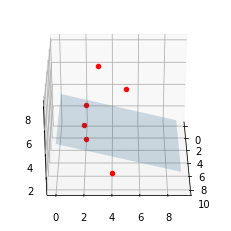

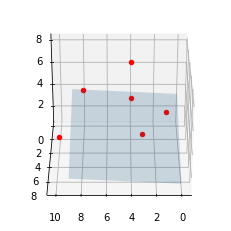

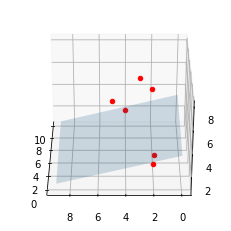

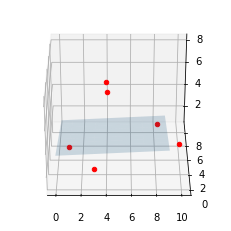

In [5]:
normal_vector_LR = get_normal_vector_of_plane_by_points_using_LR(many_points)
draw_plane_by_normal_vector_and_points(normal_vector_LR, many_points)

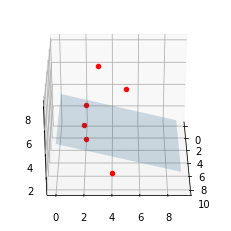

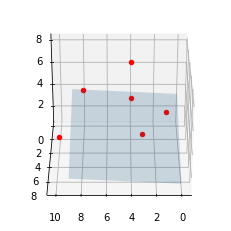

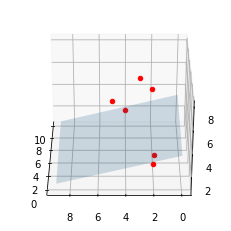

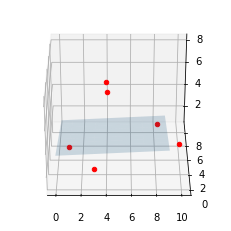

In [6]:
normal_vector_SVD = get_normal_vector_of_plane_by_points_using_SVD(many_points)
draw_plane_by_normal_vector_and_points(normal_vector_LR, many_points)

In [7]:
print(get_distance_to_all_points(many_points, normal_vector_LR))
print(get_distance_to_all_points(many_points, normal_vector_SVD))
# Already at a small number of points, it can be seen that the approach with SVD works better

[0.         0.57553101 1.00634275 0.24660835 0.45356528 1.40519912]
[1.66533454e-16 6.86000055e-02 1.22929094e+00 6.03767781e-01
 7.85583933e-01 2.05425648e-01]


In [10]:
for i in range(1, 10):
    points_dataset = np.random.randint(low=0, high=100, size=(i * 10, 3))
    dataset_normal_vector_LR = get_normal_vector_of_plane_by_points_using_LR(
        points_dataset
    )
    dataset_normal_vector_SVD = get_normal_vector_of_plane_by_points_using_SVD(
        points_dataset
    )
    MSE_LR, SE_LR = calculate_metrics(dataset_normal_vector_LR, points_dataset)
    MSE_SVD, SE_SVD = calculate_metrics(dataset_normal_vector_SVD, points_dataset)
    print(f"Dataset length {i * 10}")
    print(
        f"MSE of linear regression = {MSE_LR}, Standart error of linear regression = {SE_LR}"
    )
    print(
        f"MSE of algorithm using SVD = {MSE_SVD}, Standart error of algorithm using SVD = {SE_SVD}"
    )

Dataset length 10
MSE of linear regression = 4242.516756831467, Standart error of linear regression = 72.82270213360209
MSE of algorithm using SVD = 4177.207901606953, Standart error of algorithm using SVD = 72.26001575566319
Dataset length 20
MSE of linear regression = 2148.8728634384215, Standart error of linear regression = 48.86344763656756
MSE of algorithm using SVD = 394.36715104603286, Standart error of algorithm using SVD = 20.932886169481765
Dataset length 30
MSE of linear regression = 3396.4647070429396, Standart error of linear regression = 60.324699161906956
MSE of algorithm using SVD = 2306.2161276862444, Standart error of algorithm using SVD = 49.7086094262594
Dataset length 40
MSE of linear regression = 3627.252015826114, Standart error of linear regression = 61.791261652915516
MSE of algorithm using SVD = 3578.209255762306, Standart error of algorithm using SVD = 61.37211140817272
Dataset length 50
MSE of linear regression = 2741.184449091732, Standart error of linear r

### From the statistics obtained, it can be seen that the algorithm using SVD performs better. 

# Analogue with lines 

In [11]:
def get_normal_vector_of_line_by_points_using_LR(points: np.ndarray) -> np.ndarray:
    X_matrix = np.empty((0, 2), np.float64)
    Y_matrix = np.empty((0, 1), np.float64)
    for point in points:
        X_matrix = np.append(X_matrix, np.array([[point[0], 1]]), axis=0)
        Y_matrix = np.append(Y_matrix, np.array([[point[1]]]), axis=0)

    normal_vector = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ Y_matrix

    return normal_vector / np.linalg.norm(normal_vector)


def get_normal_vector_of_line_by_points_using_SVD(points: np.ndarray) -> np.ndarray:
    centroid = points.mean(axis=0)
    points_temp = points - centroid
    _, _, V_T = np.linalg.svd(points_temp)

    normal_vector = V_T[:, 1]

    return (normal_vector / np.linalg.norm(normal_vector)).reshape((2, 1))


points_line = np.array(
    [
        [1, 2],
        [3, 4],
        [5, 6],
        [-1, 0],
        [-2, -1],
        [-3, -2],
    ]
)

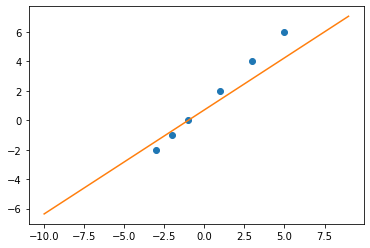

In [12]:
normal_vector = get_normal_vector_of_line_by_points_using_LR(points_line)
draw_line_by_normal_vector_and_points(normal_vector, points_line)

In [13]:
points_line = np.append(points_line, np.array([[-10, -100]]), axis=0)
points_line = np.append(points_line, np.array([[-9, -100]]), axis=0)
points_line = np.append(points_line, np.array([[-8, -100]]), axis=0)

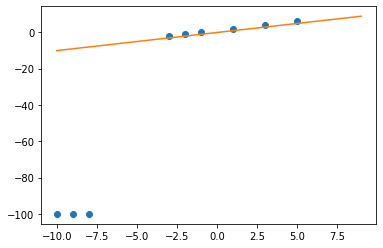

In [14]:
normal_vector = get_normal_vector_of_line_by_points_using_SVD(points_line)
draw_line_by_normal_vector_and_points(normal_vector, points_line)

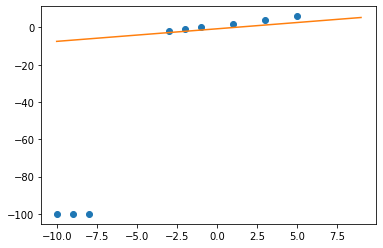

In [15]:
normal_vector = get_normal_vector_of_line_by_points_using_LR(points_line)
draw_line_by_normal_vector_and_points(normal_vector, points_line)

The above examples show that the variant in linear regression based on vertical offset greatly changes the equation of line when adding a point far from the others to the dataset. This doesn't happen with an SVD-based algorithm.

Transferring this case to three-dimensional space, we can say: if the user accidentally (or not) adds a point far from the cluster of main points, then the approach based on linear regression with vertical offset may give us the wrong equation of the plane. Using the approach SVD, the probability of such a bad event is less, because it uses a perpendicular offset.